# **Quantum Phase Estimation**
***

In this lab session, we will once again divert our attention away from studying full algorithms, and focus on something more akin to a subroutine. Just like how the
Quantum Fourier Transformation (QFT) is used as a critical element to larger algorithms, the same will be true for the focus of our lesson here: Quantum
Phase Estimation (QPE). Perhaps it's a bit unfair not to call QPE its own quantum algorithm (it's certainly derserving of the title), but the intention here is that
its full potential is realized when used for more grand algorithms. At its core, the primary function of the QPE Algorithm is to find an approximate value to an
eigenvalue phase of some unitary matrix $U$ .

In order to make sure that all cells of code run properly throughout this lesson, please run the following cell of code below:

In [87]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute 
from qiskit.visualization import plot_histogram, circuit_drawer
import random
import math as m 
import numpy as np
import scipy as sci

S_simulator = Aer.backends(name='statevector_simulator')[0]
M_simulator = Aer.backends(name='qasm_simulator')[0]

In [88]:
def Binary(N,total,LSB):
  '''
  Input: N (integer) total (integer) LSB (string)
  Returns the base-2 binary equivilant of N according to left or right least significant bit notation
  '''
  qubits = int(m.log(total, 2))
  b_num = np.zeros(qubits)
  for i in np.arange(qubits):
    if( N/((2)**(qubits-i-1)) >= 1):
      if (LSB == 'R'):
        b_num[i] = 1
      if(LSB== 'L'):
        b_num[int(qubits-(i+1))] = 1
      N = N - 2**(qubits-i-1)
  B = []
  for j in np.arange(len(b_num)): 
    B.append(int(b_num[j]))
  return B

In [89]:
def From_Binary(S, LSB):
    '''
    Input:
    S (string or array)
    LSB (string)
    Converts a base-2 binary number to base-10 according to left or right least significant bit notation
    '''
    num = 0
    for i in np.arange(len(S)):
    	if(LSB=='R'):
    		num = num + int(S[int(0-(i+1))]) * 2**(i)
    	if(LSB=='L'):
    		num = num + int(S[int(i)]) * 2**(i)
    return num

In [90]:
'''
Do not worry about the length of this code block.
You dont need to understand this code.
It is only to help you view the wavefunction in a better way
'''


def Wavefunction( obj, *args, **kwargs):
  '''
  Displays the wavefunction of the quantum system
  '''
  if(type(obj) == QuantumCircuit ):
    statevec = execute( obj, S_simulator, shots=1 ).result().get_statevector() 
  if(type(obj) == np.ndarray):
    statevec = obj
  sys = False
  NL = False
  dec = 5
  if 'precision' in kwargs:
    dec = int(kwargs['precision'] )  
  if 'column' in kwargs:  
    NL = kwargs['column']
  if 'systems' in kwargs:
    systems=kwargs['systems']
    sys = True
    last_sys= int(len(systems)-1)
    show_systems = []
    for s_chk in np.arange(len(systems)): 
      if( type(systems [s_chk])!=int ):
        raise Exception('systems must be an array of all integers')
    if 'show_systems' in kwargs: 
      show_systems = kwargs['show_systems']
      if(len(systems)!=len (show_systems) ):
        raise Exception('systems and show_systems need to be arrays of equal length')
      for ls in np.arange(len(show_systems)): 
        if((show_systems [ ls]!=True) and (show_systems [ ls] !=False)): 
          raise Exception('show_systems must be an array of Truth Values') 
        if(show_systems [ ls] ==True): 
          last_sys= int(ls)

    else:
      for ss in np.arange(len(systems)): 
        show_systems.append(True)
  wavefunction = ''
  qubits = int(m.log(len(np.asarray(statevec)),2)) 
  for i in np.arange( int(len(np.asarray(statevec))) ): 
    value = round(statevec[int(i)].real, dec) + round(statevec[int(i)].imag, dec) * 1j
    if( (value.real!=0) or (value.imag!=0)): 
      state= list(Binary(int(i), int(2**qubits),'L'))
      state_str = ''
      if( sys == True ):    #Systems and Show Systems
        k = 0 
        for s in np.arange(len(systems)):
          if(show_systems [s]==True):
            if(int(s)!=last_sys):
              state.insert(int(k+systems [s]), '>|' ) 
              k = int(k+systems[s]+1)
            else:
              k = int(k+systems[s])
          else:
            for s2 in np.arange(systems [s]): 
              del state[int(k)]
      for j in np.arange(len(state)):
        if(type(state[j])!=str):
          state_str = state_str+str(int(state[j]))
        else:
          state_str = state_str+state[j]
      if ((value.real!=0) and (value.imag!=0)):
        if( value.imag> 0):
          wavefunction = wavefunction + str(value.real) + '+' + str(value.imag) + 'j |' + state_str + '>   '
        else:
          wavefunction = wavefunction + str(value.real) +'' + str(value.imag) + 'j |' + state_str + '>    '
      if( (value.real!=0) and (value.imag==0)): 
        wavefunction = wavefunction +str(value.real)+' |'+state_str +'>     '
      if((value.real==0) and (value.imag!=0)): 
        wavefunction = wavefunction +str(value.imag)+'j |'+state_str+ '>     '
      if (NL):
        wavefunction = wavefunction + '\n'
  print(wavefunction)


In [91]:
def Measurement(quantumcircuit, **kwargs):
  '''
  Executes a measurement(s) of a QuantumCircuit object for tidier printing
  Keyword Arguments:
  shots (integer) - number of trials to execute for the measurement(s)
  return_M (Bool) - indictaes whether to return the Dictionary object containng measurement resul
  print_M (Bool) - indictaes whether to print the measurement results
  column (Bool) - prints each state in a vertical column
  '''
  p_M = True
  S=1
  ret = False
  NL = False
  if 'shots' in kwargs:
    S = int(kwargs['shots'])
  if 'return_M' in kwargs:
    ret = kwargs['return_M']
  if 'print_M' in kwargs:
    p_M = kwargs['print_M']
  if 'column' in kwargs:
    NL = kwargs['column']
  M1 = execute(quantumcircuit, M_simulator, shots=S).result().get_counts(quantumcircuit)
  M2 = {}
  k1 = list(M1.keys())
  v1 = list(M1.values())
  for k in np.arange(len(k1)):
    key_list = list(k1[k])
    new_key = ''
    for j in np.arange(len(key_list)):
      new_key = new_key+key_list[len(key_list)-(j+1)]
    M2[new_key] = v1[k]
  if(p_M):
    k2 = list(M2.keys())
    v2 = list(M2.values())
    measurements = ''
    for i in np.arange( len(k2) ):
      m_str = str(v2[i])+'|'
      for j in np.arange(len(k2[i])):
        if( k2[i][j] == '0' ):
          m_str = m_str+'0'
        if( k2[i][j] == '1' ):
          m_str = m_str+'1'
        if( k2[i][j] == ' ' ):
          m_str = m_str+'>|'
      m_str = m_str+'>   '
      if(NL):
        m_str = m_str + '\n'
      measurements = measurements + m_str
    print(measurements)
  if(ret):
    return M2

In [92]:
def QFT_dgr (qc, q, qubits, **kwargs):
  '''
  Input: qc (QuantumCircuit), q (QuantumRegister), qubits (integer)
  Keyword Arguments: swap (Bool) - Adds SWAP gates after all of the phase gates have been applied 
  Assigns all the gate operations for a Quantum Fourier Transformation
  '''
  if 'swap' in kwargs:
    if(kwargs['swap'] == True):
      for s in np.arange(m.floor(qubits/2.0)):
        qc.swap( q[int(s)],q[int(qubits-1-s)] )
  
  R_phis = [0]

  for i in np.arange(2,int(qubits+1)):
    R_phis.append(-2/(2**(i))*m.pi )
  
  for j in np.arange(int(qubits)): 
    for k in np.arange( int(j) ):
      qc.cp(R_phis[int(qubits - (k+1))], q[int(qubits - (k+1))], q[int(qubits - (j+1))] )
    qc.h( q[int(qubits - (j+1))] )

## **Solving for Eigenvalues**
***

As the name of the algorithm suggests, the QPE subroutine is a technique for finding eigenvalue phases of a unitary matrix. The goal is to compute the eigenvalue for a matrix $U$, with an eigenvector $|u⟩$
, where the eigenvalue can be written into the specific form $ e^{2πiθ}$
:

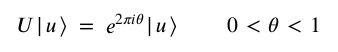

The final result from the algorithm will be to produce the value of 𝜃, either exactly or to some desired precision. Broadly speaking, the QPE algorithm is
particularly useful for quantum computing because we work exclusively with unitary operators, for which we are always guaranteed that its eigenvalues satisfy
our conditions. For example, below is a generalized single qubit unitary matrix, and an example value to demonstrate a pair of eigenvalues:

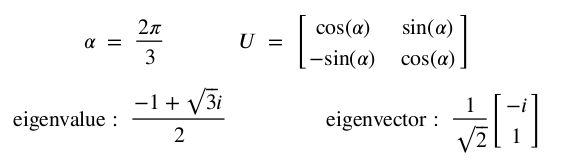

In [93]:
alpha = 2*m.pi/3
U = np.array([ [ np.cos(alpha) , np.sin(alpha) ], 
              [ -np.sin(alpha) , np.cos(alpha) ] ])
#---------------------------------------------------
e = 0.5*(-1+m.sqrt(3)*1.0j)
v = 1.0/m.sqrt(2)*np.array([-1.0j,1] )
#---------------------------------------------------

print('____ Unitary Matrix ____\n',U)
print( '\n U |u> = ',np.dot(U,v))
print( 'e^{2\u03C0i\u03C6} |u> = ',e * v)

____ Unitary Matrix ____
 [[-0.5        0.8660254]
 [-0.8660254 -0.5      ]]

 U |u> =  [ 0.61237244+0.35355339j -0.35355339+0.61237244j]
e^{2πiφ} |u> =  [ 0.61237244+0.35355339j -0.35355339+0.61237244j]


The code above simply demonstrates the relation between a unitary matrix and its eigenvectors / eigenvalues. We can rewrite the eigenvalue from this
example into the form shown above as well:

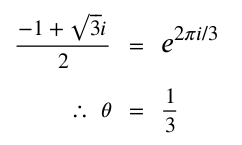

Thus, if we were to successfully run our QPE algorithm using the matrix above, we would find with high probability the value of
𝜃 = $\frac{1}{3}$ . Although the
capabilities of this algorithm may seem a little singular at first glance, only being a tool for finding eigenvalues, the applications for QPE make it one of the
most important quantum subroutines to date.

## **The QPE Circuit**
***

To begin our study of the QPE algorithm, let's first take a look at its circuit diagram, taking special note of a new element which we've yet to encounter before:

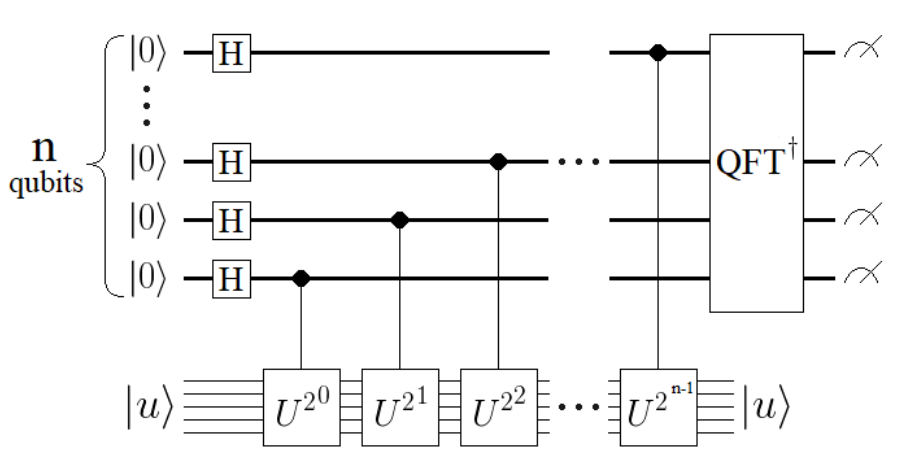

All of the elements in the circuit above should look familiar, with the exception of the control-$U$ operations in the middle. Like many algorithms, our circuit begins with $H$ gates on all of our qubits, creating an equal superposition of all states:

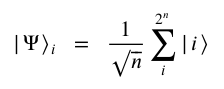

But even in this first step, there is already something fundamentally new about this algorithm, and that's the number n. In previous algorithms, the number of
qubits was determined by certain constraints or conditions of our problem. For example, in Grover's Algorithm the number of qubits we used was determined
by the total number of possible entries on which we were performing the search. Here, n is actually a number of our choosing, representing the level of
precision we would like out of the algorithm. In principle we can use as many or as few qubits as we want, and our QPE will fundamentally run all the same.

We will return to n and its impact on the algorithm, but for now let's turn our attention to the second new feature:  $|u⟩$. At the bottom of our circuit diagram, we
can see a second qubit register, one that needs to be prepared in the state of our eigenvector.Skipping forward, if we look at the state of this second register
after all of the control-$U$ operations, our eigenvector $|u⟩$ comes out unchanged. Conceptually, this agrees with our discussion of unitary matrices and
eigenvectors from earlier: $ U|u⟩ = e^{2πiθ} |u⟩$. All of the quantum operations that are being applied to the qubits in the second register are in principle
applications of $U$, which means that the state of the qubits should remain unchanged. Consequently then, we must ask what is the result of all these
operations?

If the effect of all the control-$U$ operations leaves the second register unchanged, then it would be fair to assume their effect must show up on the first
register. This is indeed the case, and to see this, let's focus on a single application of a control-$U$ :

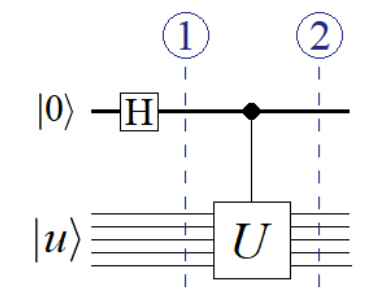

Following along with the diagram above, the state of our quantum system at (1) is straightforward:

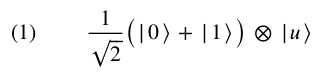

Next let's take a look at what the control-$U$ operation is doing. Because our control qubit is sitting in the $|+⟩$ superposition state, we know that the effect of the control-$U$ operation will only be applied to the $|1⟩$
component:

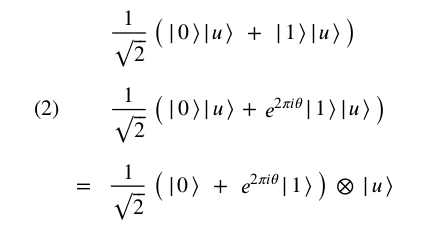

As shown above, the |1⟩ component of our first register qubit has picked up the $𝑒^{2𝜋𝑖𝜃}$ phase from 𝑈 , leaving the |0⟩ unchanged. Additionally, we can see in
the last line that the effect of 𝑈 acting on |𝑢⟩ has left the eigenstate unaltered, just as we discussed earlier. The steps outlined above represent the individual
action of each control-𝑈 operation on the qubits, so now let's connect this result to the various unitary operations outlined in the complete circuit. In particular,
all of the control-𝑈 operations required of the full QPE circuit are essentially powers of $𝑈^2$. Mathematically, the expected result from these operations is as
follows:

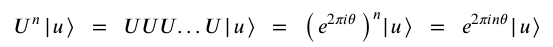

Essentially, each application of 𝑈 on |𝑢⟩ results in a multiplication of $𝑒^{2𝜋𝑖𝜃}$ onto the |1⟩ component of the respective control qubit. Thus, 𝑛 applications of 𝑈
results in 𝑛 copies of this phase term all being multiplied together, which can be combined nicely using exponential power laws. Putting all of the various
control-𝑈 operations outlined in the circuit together then, the state of our system just before the $QFT^†$ will be:

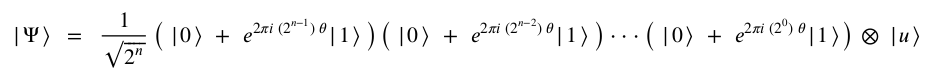

If you follow along the circuit diagram, you should be able to correctly spot where each of the phase contributions are coming from in the state above. In total, we have all of the powers from $2^0$
through $2^n$
distributed amongst the phases of our n qubits. In the next
section we are going to dissect the state above further and examine the effect of passing it through an inverse Quantum Fourier Transformation.

## **Final Step: $QFT^†$**
***

Following from the state shown above, the final step of our QPE circuit requires a $QFT^†$ , which suggests that there is something special about the way in
which all of the phase terms are arranged. For example, why does the circuit call for powers of $U^{2^{n}}$ rather than just $U^{n}$? To start, let's recall the way in which a $QFT^†$ applies phases on the various qubits in the system:

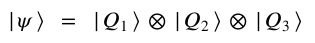

where we will assume each of the states | $𝑄_𝑖$ ⟩ ∈ { |0⟩,|1⟩ }

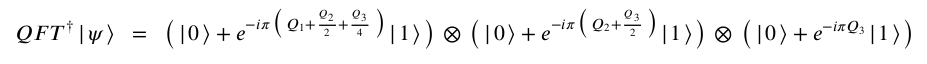

In particular, we can see exactly the way in which the phases on each qubit's $|1⟩$ state component are determined by which qubits in $|\psi⟩$ are
in either $|0⟩$ or $|1⟩$. In a sense, we can think of these phase contributions as a "fingerprint" for the final quantum state, for example:

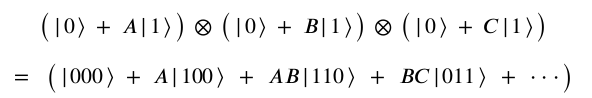

Notice in the example above how each state's phase is unique, and can be traced exactly to $|1⟩$ states that it's composed of. In a similar way, the same can
be said for the $QFT^{†}$ , and the way in which each $|\psi⟩$ leads to a unique final combination of phases (not every individual state component from each $QFT^{†}$ $|\psi⟩$ is unique, but rather the total combination of phases across all the state components). To see the resulting phase on a single state, we need only
multiply out the $|0⟩$ and $|1⟩$ contributions that make up a particular computational basis state $|\psi_{k}⟩$. For example:

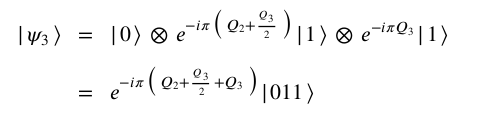

Note in the expression above the way in which 𝑘 = 3 translates to the state |011⟩ , indicating that we are interpreting our quantum states as rightmost LSB binary numbers. Keeping this in mind, for a better understanding of how our QPE algorithm is going to work, we actually want to switch our $QFT^†$ focus. Specifically, rather than focusing on where the phase contributions are coming from on an individual | $𝜓_𝑘$ ⟩ component, we're interested in all the phases produced from a single $QFT^†|𝜓_𝑗⟩$:

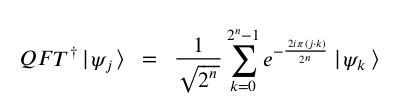

We can quickly confirm the expression above with the cell of code below:

In [94]:
q = QuantumRegister(3,name='q' )
qc= QuantumCircuit(q,name='qc')
#-------------------------------
qc.x( q[1] )
qc.x( q[2] )
print('____ Initial State ____')
Wavefunction(qc)
qc.swap( q[0], q[2] )
QFT_dgr( qc,q,3 )
print('\n____ After QFT\u2020 ____')
Wavefunction(qc)
#======================================
print('\n ____ QFT\u2020 Expression ____')
for k in np.arange( 8 ):
  phase = 1.0/(m.sqrt(8)) * np.exp( -1.0j*m.pi*( (3*k)/4 ) )
  print( 'state: ',Binary(int(k),8,'R'),'phase: ',round(phase.real,4)+round(phase.imag,4)*1.0j )

____ Initial State ____
1.0 |011>     

____ After QFT† ____
0.35355 |000>     -0.35355 |100>     0.35355j |010>     -0.35355j |110>     -0.35355j |001>     0.35355j |101>     0.35355 |011>     -0.35355 |111>     

 ____ QFT† Expression ____
state:  [0, 0, 0] phase:  (0.3536+0j)
state:  [0, 0, 1] phase:  (-0.25-0.25j)
state:  [0, 1, 0] phase:  0.3536j
state:  [0, 1, 1] phase:  (0.25-0.25j)
state:  [1, 0, 0] phase:  (-0.3536+0j)
state:  [1, 0, 1] phase:  (0.25+0.25j)
state:  [1, 1, 0] phase:  -0.3536j
state:  [1, 1, 1] phase:  (-0.25+0.25j)


As we can see, the expression does indeed give us the correct phases produced from the $QFT^†$. As an aside, please note the additional SWAP gate in our
quantum circuit above, just before the QFT. Interpreting the quantum states from a Quantum Fourier Transformation as
rightmost LSB binary numbers requires that we use SWAP gates at the end of a QFT. Consequently, when we want to perform a $QFT^†$ using the same convention, these SWAP gates come before the $QFT^†$  (remember that the $QFT^†$  circuit is a mirrored version of the QFT circuit, with opposite phases). In the
code above we put the SWAP gate in deliberately for demonstration purposes, but in future examples we will make use of our
's built in keyword
"swap."

In a similar fashion to the expression shown above, we can describe the resulting state of our system after all of the control-
the same manner:

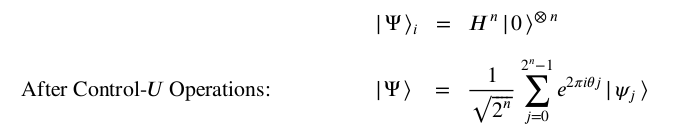

As an example, let's take a closer look at a single $|𝜓_𝑗 ⟩$ state, say 𝑗 = 6 for 𝑛 = 3. According to the formula above, the resulting phase on this state should
be:

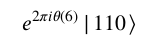

We can confirm that this is indeed the same phase that our QPE circuit will produce by carrying out the multiplication from earlier:

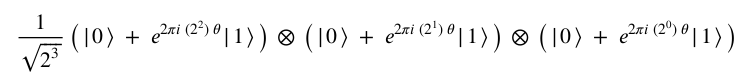

focusing specifically on the phase on |110⟩:

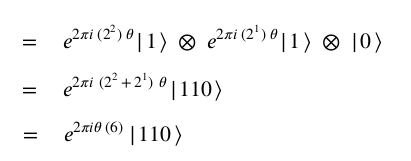

I encourage you to work through a few more $|𝜓_𝑗⟩$ cases for yourself, proving that the formulation for the control-𝑈 operations is indeed correct. Now, with
the two equations above for expressing the control-𝑈 and $QFT^†$ operations in hand, we are ready to write down the final state of our system, the complete
result of the QPE circuit. We will start by writing down the effect of the final $QFT^†$ on one of these $|𝜓_𝑗⟩$ states produced after the control-𝑈 operations:

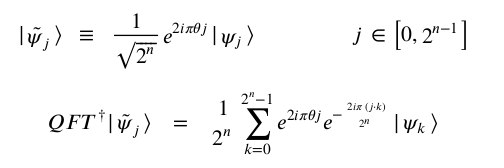

which we can rearrange into something more revealing about the final states:

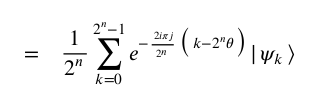

And lastly, we now add back in the eigenstate |𝑢⟩ and the summation over 𝑗, showing the full effect of the $QFT^†$ on all of the $|𝜓̃_𝑗⟩$ states:

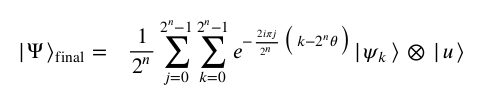

We have now finally reached the concluding state of our quantum system after the QPE circuit! What we've accomplished with the state above may not jump
out at you straight away, but a measurement on this system is promised to reveal the phase $θ$ with high probability. In the next section we are going to see
exactly why this is, as well as the role of n in increasing the precision of our result, but for now let's see this final state in action. The cell of code below is a
classical version of the equation shown above, where $θ$  = 0.52 and n = 3:

In [114]:
n = 3
theta = 0.2
print('Theta = ',theta,'n = ',n,'\n---------------------------')
#===================
state = []
bstate = []
bdec = []
for i in np.arange(2**n):
  state.append(0)
  bstate.append(Binary(int(i),2**n,'R'))
  bc = 0
  for i2 in np.arange(len(bstate[i])):
    bc = bc + ( 1.0/(2**(int(i2)+1)) )*int(bstate[i][i2])
  bdec.append(bc)
#-------------------------------------------------------------
for y in np.arange(2**n):
  for x in np.arange(2**n):
    state[int(y)] = state[int(y)] + 1.0/(2**n) * np.exp( (-2.0j*np.pi*x/(2**n))*(y-2**n*theta) )
#--------------------------------------------------------------
for j in np.arange(2**n):
  print('Probability: ',round( abs(state[j])**2,4 ),'State: ',bstate[j],'Binary Decimal: ',bdec[j])

Theta =  0.2 n =  3 
---------------------------
Probability:  0.0409 State:  [0, 0, 0] Binary Decimal:  0.0
Probability:  0.2593 State:  [0, 0, 1] Binary Decimal:  0.125
Probability:  0.5775 State:  [0, 1, 0] Binary Decimal:  0.25
Probability:  0.0518 State:  [0, 1, 1] Binary Decimal:  0.375
Probability:  0.0216 State:  [1, 0, 0] Binary Decimal:  0.5
Probability:  0.0149 State:  [1, 0, 1] Binary Decimal:  0.625
Probability:  0.0145 State:  [1, 1, 0] Binary Decimal:  0.75
Probability:  0.0194 State:  [1, 1, 1] Binary Decimal:  0.875


## **Approximating The Phase With $2^n θ$**
****

The coding example above represents the states and probabilities we will later expect from our quantum system (after we've covered how to physically
implement our control-$U$ operators). If you haven't already, I encourage you to run the example above a few times, changing the values of $θ$ and n and
seeing some of the various results. In particular, below are some recommended combinations to test, and the resulting probabilities you should find:

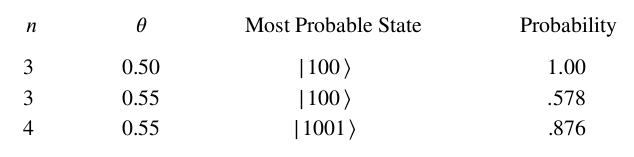

Now, let's discuss the impact of the results found from these three combinations. In our first example, we are trying to find the phase $θ$ = 0.5,and our QPE
algorithm is returning to us the state $|100⟩$ with a 100\% probability. However, for the same number of qubits, n = 3, trying to find a slightly different phase of $θ$ = 0.55 results in a dramatic decrease in success, but the same most probable state. And lastly, by increasing the value of n to 4, we are able to
significantly boost our success rate, but consequently get a different most probable state.

If we combine the results from all three of these examples, you may start to get a sense for how this algorithm is working. The first example suggests that for
certain values of $θ$ we can obtain perfect success rates, while the second and third are indicative that for other cases of $θ$ we cannot. However, for these non-
special values of $θ$, we can boost our chances of measuring the most probable state by increasing n, but consequently must interpret the new state made up
of more qubits. Keeping these observations in mind, let's now dig a little deeper into the answers our QPE is giving us, and more importantly why.

## **Interpreting Our QPE Results**
****

As crucial as it is to our understanding of QPE, up until this point we have made no comments as to what the final states of our system are meant to
represent, and how we can tell a "correct" final state from a "wrong" one. The answer to this important question is that the final states of the QPE algorithm
are designed to represent binary decimals. As a quick reminder, a binary decimal is the equivalent to our standard base-10 decimal system, but for binary numbers.Whereas a typical decimal represents increasing powers of $\frac{1}{10}$ , a binary decimal can be used to represent numbers between 0 and 1 in terms of powers of $\frac{1}{2}$. For example, take a look at the following numbers and their decimal representations:

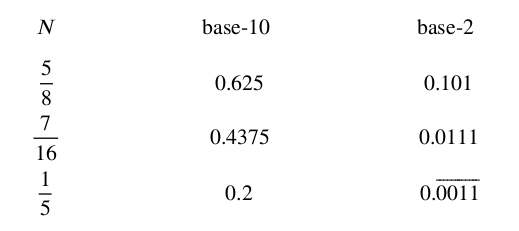

Looking at the fraction $\frac{7}{16}$ in deeper detail:
$$ base 10 :  0.4375 =  4×\frac{1}{10} + 3×\frac{1}{100} + 7×\frac{1}{1000} + 5×\frac{1}{10000}  $$
$$ base 2 : 0.0111 = 0×\frac{1}{2} + 1×\frac{1}{4} + 1×\frac{1}{8} + 1×\frac{1}{16}  $$

For our QPE algorithm, after we make a measurement on the system in the computational basis and get our final state, we convert that state into a binary
decimal and that's our approximation to $θ$! With this new insight, I encourage you to return to the coding example above and see for yourself that indeed the
states which were most probable correspond to the closest binary decimal representations to $θ$.

## **Accuracy of the Approximation**
****

As our final topic before moving on to the physical implementation of the QPE algorithm into a quantum circuit (specifically the control-$U$ operators), we need
to discuss the accuracy of QPE and the dependence on n. Originally, we said earlier that increasing n will improve the accuracy of our algorithm, and the
quick examples above seemed to suggest the same thing. Specifically, in attempting to discover θ = 0.55 and n = 3 gives us a probability of 0.578 for $|100⟩$ while n = 4 gave us a probability of 0.876 for $|1001⟩$ . In interpreting these results as binary decimals, we get the values 0.5 and 0.5625 respectively. While this particular example demonstrated that increasing the number of qubits yielded a better final answer, it turns out that this is not always
the case. In actuality, the real purpose in choosing an n is to create a state closest to θ, while simultaneously creating the largest separation possible from
this closest state to all other states in the system. For example:

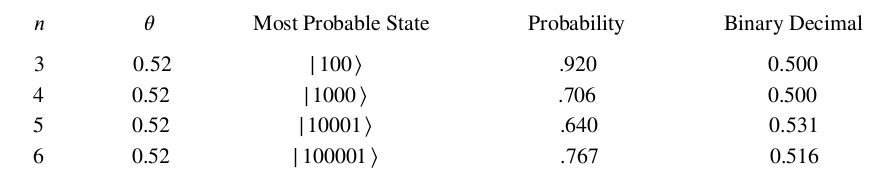

Take a look at the examples above, and the resulting most probable states as we increase 𝑛 from 3 to 6. In the first two examples, we find that bumping up our number of qubits to 4 results in the same binary decimal answer, but with a significantly lower probability. Then as we increase to 𝑛 = 5, we once again sacrifice some probability on the most probable state, but in turn our binary decimal interpretation is closer to the true value of 𝜃. And lastly, going from 𝑛 = 5
to 6 yields not only a better binary decimal approximation, but a higher probability as well! Suffice to say, the examples above demonstrate that more is not always better for QPE, as increasing 𝑛 isn't always guaranteed to yield a better final state. It's true that increasing 𝑛 allows for closer approximations to 𝜃, but
we must always keep in mind the costs in doing so, both in probabilities and circuit size.

Conceptually, QPE algorithm will give us the phase θ we're looking for with 100\% probability, if it can be perfectly represented as a binary decimal. But now suppose we're interested in a state $|m⟩$ that is not a perfect binary decimal representation of θ. If we are no longer dealing with a state  $|m⟩$ such that $2^nθ = m$, then instead we can express our phase quantity as $2^nθ = m + ϕ$, where is ϕ essentially the difference between θ and our state $|m⟩$

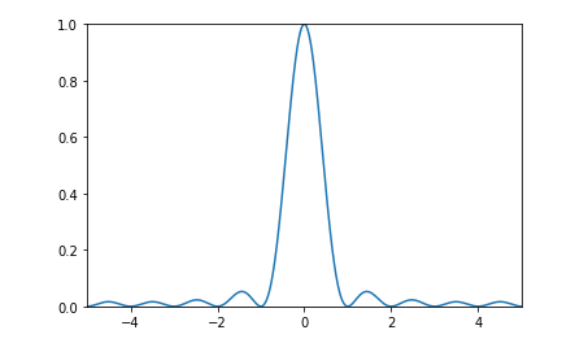

The plot above shows the provability vs ϕ curve.



## **Determining $θ$ Through Multiple Measurements**
***

Having just seen how the accuracy of a QPE run can vary depending on the θ we are trying to find and the number of qubits we choose to use for our binary
decimal representations, relying on a single measurement to give us our final answer can feel a bit unsettling. In particular, an unlucky measurement could
give us a Θ value that is completely wrong, essentially defeating the whole purpose of the algorithm. And even worse still, if we do run our QPE multiple times
to properly determine the most probable $|m⟩$ , if the results clearly show that θ lies somewhere between some $|m⟩$ and $|m'⟩$ , we have no means of getting a
better approximation without increasing n and starting all over.

Even though we're no strangers to the measurement dilemma in quantum algorithms, it would still be nice to have a more concrete methodology for
determining θ. And while in certain instances we may not have the luxury of running QPE multiple times (for example if we are using QPE as a subroutine
inside of a larger algorithm), for now let's assume we do. As we shall see, even though certain values of θ are unfeasible for exact binary decimal
representations, building up a statistic of measurements will allow us to reconstruct θ from the binary decimal states we can implement. To do this, we must
first return to our formula for the probability of measuring $|m⟩$:

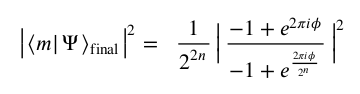

Let us now suppose we can obtain the left hand side of this equation through repeat measurements. Specifically, we run our QPE circuit enough times to
determine the closest $|m⟩$, and substitute its probability into the equation above. In doing so, we could then solve for ϕ, which would ultimately allow us to
solve for θ:  

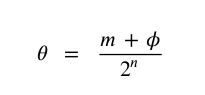

The key here is that we need enough measurements to determine the closest $|m⟩$ to θ , that way we can be certain to solve for a value of ϕ that lies between
0 and 1. Specifically, since our $| ⟨𝑚|Ψ_{final} ⟩ |^2$ function has the same value for multiple instances of 𝜙 (to see this, look back at our plot from earlier), we need to work within the region of 𝜙 where our function is one-to-one. Technically there is no where in our space where this is true, but if we know we are dealing
with the most probable |𝑚⟩, then we can be certain 𝜙 ∈ [ − 0.5,0.5]. . And if we look at the second most probable state | 𝑚′⟩ in our system, we can determine whether or not our solved value for 𝜙 should be positive or negative.



In [96]:
def QPE_phi(MP):
  '''
  Input:
  array( [[float,float],[string,string]] )
  Takes in the two most probable states and their probabilities, returns phi and the approximate theta for QPE
  '''
  ms = [[],[]]
  for i in np.arange(2):
    for j in np.arange(len(MP[1][i])):
      ms[i].append(int(MP[1][i][j]))
  n = int(len(ms[0]))
  MS1 = From_Binary(ms[0],'R')
  MS2 = From_Binary(ms[1],'R')
  PHI = [99,0]
  for k in np.arange(1,5000):
    phi = k/5000
    prob = 1/(2**(2*n)) * abs( (-1 + np.exp(2.0j*m.pi*phi) )/(-1 + np.exp(2.0j*m.pi*phi/(2**n))) )**2
    if( abs( prob - MP[0][0] ) < abs( PHI[0] - MP[0][0]) ):
      PHI[0] = prob
      PHI[1] = phi
  if( (MS1 < MS2) and ( (MS1!=0) and (MS2!=(2**n-1)) ) ):
    theta = (MS1+PHI[1])/(2**n)
  elif( (MS1 > MS2) and (MS1!=0) ):
    theta = (MS1-PHI[1])/(2**n)
  else:
    theta = 1+(MS1-PHI[1])/(2**n)
  return PHI[1],theta

In [97]:
def Most_Probable(M,N):
  '''
  Input:
  M (Dictionary),N (integer)
  Returns the N most probable states accoding to the measurement counts stored in M
  '''
  count = []
  state = []
  if( len(M) < N ):
    N = len(M)
  for k in np.arange(N):
    count.append(0)
    state.append(0)
  for m in np.arange(len(M)):
    new = True
    for n in np.arange(N):
      if( (list(M.values())[int(m)] > count[int(n)]) and (new) ):
        for i in np.arange( int(N-(n+1)) ):
          count[-int(1+i)] = count[-int(1+i+1)]
          state[-int(1+i)] = state[-int(1+i+1)]
        count[int(n)] = list(M.values())[m]
        state[int(n)] = list(M.keys())[m]
        new = False
  return count,state

To demonstrate this approximation technique, below is a simulated version of our 𝜃 = 0.52, 𝑛 = 4 example from earlier:

In [98]:
Prob = [ 0.0028,0.0028,0.0031,0.0037,0.0049,0.0076,0.0144,0.0424,0.7063,0.1571,0.0265,0.011,0.0064,0.0044,0.0035,0.003 ]
Measured = np.zeros( len(Prob) )
trials = 10000
n = 4
#======================================== Simulate measurements on the final system
for t in np.arange(trials):
  M = random.random()
  p = 0
  for s in np.arange( len(Prob) ):
    if( p < M < (p + Prob[s]) ):
      Measured[s] = Measured[s] + 1
    p = p + Prob[s]
#---------------------------------------
MD = {}
for i in np.arange( len(Prob) ):
  state = Binary(int(i),2**n,'R')
  state_str = ''
  for j in np.arange(len(state)):
    state_str = state_str+str(state[j])
  MD[state_str] = int( Measured[i] )
MP = Most_Probable(MD,2)
for mp in np.arange(2):
  MP[0][mp] = MP[0][mp]/trials
#======================================== Compute phi using the most probable state
phi,theta = QPE_phi(MP)
print('\nMost Probable State:|'+str(MP[1][0])+'> Probability: ',round(MP[0][0],5))
print('\nCorresponding \u03A6: ',phi,'\n\nApproximate \u03B8: ',round(theta,5))


Most Probable State:|1000> Probability:  0.7083

Corresponding Φ:  0.3188 

Approximate θ:  0.51992


Success! In the cell of code above we blindly measure our quantum system 10,000
times to get an approximate probability for our closest $|m⟩$. We then use
this approximate probability to determine ϕ using the function QPE_phi(), and ultimately compute our approximate value to θ. And as you can see, even
though there isn't a quantum state in our system which is an exact binary decimal representation of θ, our technique has determined with some impressive
accuracy!

An important thing to point out about the technique above is that it is essentially independent of n, the qubit accuracy of our QPE. That is to say, increasing n doesn't help us approximate θ any better, only increasing the number of measurements. Thus, we would ideally want to apply this approximation technique
with the lowest n we can in order to decrease our total gate count / run time. We will return to this approximation approach one more time in this lesson, after
we can properly implement QPE circuits.

## **Implementing the Unitary Operator**
***

We have now finally reached the point in this lesson where we will actually be running QPE as a quantum circuit. Having now fully covered the QPE algorithm
in mathematical detail, our last task is to construct it using quantum gates. If you're curious as to why we put off this section to the end, it's because unlike
other quantum algorithms, there is no set way for implementing QPE. Aside from the general structure of the quantum circuit outlined earlier, how one chooses to implement the control-$U$ operators and eigenstate $|u⟩$ is an open question. Thus, all of the mathematics for QPE hold true for any
implementation, which is why we elected to cover them first, rather than diving straight into building a few example circuits.

To begin, we will first turn our attention towards the control-$U$ operators, for which we must determine their eigenvalue $θ$. Before attempting to construct the full set of control-$U^{2^n}$ operators, we will start by focusing on implementing a single control-$U$ on one of its eigenstates $|u⟩$. We certainly have no shortage of
unitary operators available to us in our standard set of quantum gates from Qiskit, but implementing them as control gates and preparing $|u⟩$ is often times
more tricky. Luckily for us, there is at least one simple example that we can try:
.

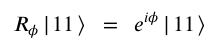

The control-phase gate is an ideal first example to test our algorithm, particularly because its eigenvalue is a free parameter. Thus, in order to make this gate
match our eigenvalue template $2πiθ$ , all we need to do is factor the $2π$ into our $ϕ$ (please note that this is not the same $ϕ$ from our discussions earlier, but
merely the standard notation for the control-phase gate):

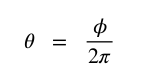

For the $𝑅_𝜙$ gate, the eigenstate we need to prepare is as simple as it gets: |1⟩. And similarly, the various powers of our control-$𝑈^2$ operators is achieved by
repetitive uses of $𝑅_𝜙$ . Let's first take a look at the state of the system after we apply all of these control operators:

In [99]:
n = 3
q1 = QuantumRegister(n,name='q1')
q2 = QuantumRegister(1,name='q2')
qc = QuantumCircuit(q1,q2,name='qc')
theta = 0.52
phi = 2*m.pi*theta
#---------------------------------------------------
for i in np.arange(n):
  qc.h(q1[int(i)])
qc.x( q2[0] )

for j in np.arange(n):
  for k in np.arange(2**j):
    qc.cp( phi, q1[int(n-1-j)], q2[0] )
print('\n___ After Control-U Operations ___')
Wavefunction( qc, systems=[n,1] )
#---------------------------------------------------
Phases = [np.exp(4.0j*phi),np.exp(2.0j*phi),np.exp(1.0j*phi)]
print(' ')
for i in np.arange(8):
  state = Binary(int(i),8,'R')
  phase = m.sqrt(1/8)
  for j in np.arange(3):
    if(state[j]==1):
      phase = phase*Phases[j]
  print('State: ',state,'Phase: ',round(phase.real,5)+round(phase.imag,5)*1.0j)


___ After Control-U Operations ___
0.35355 |000>|1>     0.30982+0.17033j |100>|1>   0.34245+0.08793j |010>|1>   0.25773+0.24202j |110>|1>   -0.35077-0.04431j |001>|1>    -0.28603-0.20781j |101>|1>    -0.32873-0.13015j |011>|1>    -0.22536-0.27242j |111>|1>    
 
State:  [0, 0, 0] Phase:  (0.35355+0j)
State:  [0, 0, 1] Phase:  (-0.35077-0.04431j)
State:  [0, 1, 0] Phase:  (0.34245+0.08793j)
State:  [0, 1, 1] Phase:  (-0.32873-0.13015j)
State:  [1, 0, 0] Phase:  (0.30982+0.17033j)
State:  [1, 0, 1] Phase:  (-0.28603-0.20781j)
State:  [1, 1, 0] Phase:  (0.25773+0.24202j)
State:  [1, 1, 1] Phase:  (-0.22536-0.27242j)


The cell of code above achieves the desired phases from the control-$U^2$ operations on our quantum system, and then confirms each phase classically. Note how easily we were able to implement the control-$U^{2^n}$ operations, simply applying the CU1 gate he correct number of times in succession.

With our control-$U$ operators successfully achieved, all that's left to do is apply the $QFT^†$ and make a measurement on the system:


___ After QFT_dgr ___
0.02569-0.0546j |000>|1>    0.86777+0.40834j |100>|1>   0.07553-0.02719j |010>|1>    -0.03085-0.08568j |110>|1>    0.07311-0.02632j |001>|1>    -0.07687-0.21353j |101>|1>    0.05332+0.02509j |011>|1>   0.01229-0.02612j |111>|1>    


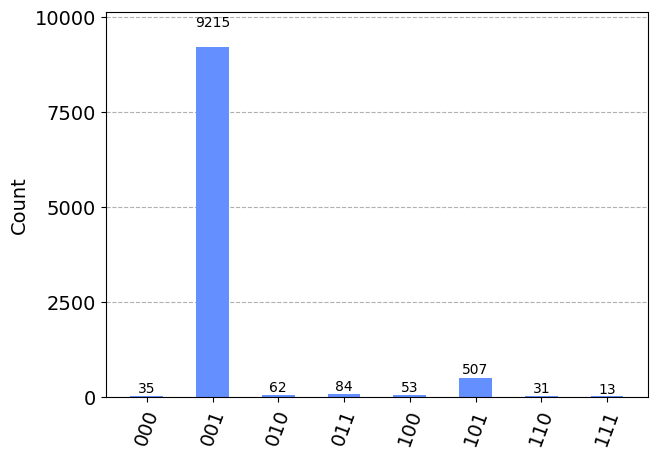

In [100]:
n = 3
q1 = QuantumRegister(n,name='q1')
q2 = QuantumRegister(1,name='q2')
c = ClassicalRegister(n,name='c')
qc = QuantumCircuit(q1,q2,c,name='qc')
theta = 0.52
#---------------------------------------------------
for i in np.arange(n):
  qc.h(q1[int(i)])
qc.x( q2[0] )
phi = 2*m.pi*theta
for j in np.arange(n):
  for k in np.arange(2**j):
    qc.cp( phi, q1[int(n-1-j)], q2[0] )
print('\n___ After QFT_dgr ___')
QFT_dgr( qc,q1,n,swap=True )
Wavefunction( qc, systems=[n,1] )
#---------------------------------------------------
qc.measure(q1,c)
results = execute(qc, Aer.get_backend('qasm_simulator'), shots=10000).result()
plot_histogram(results.get_counts())

As we can see in the final amplitudes, the state $|100⟩$ is overwhelmingly more probable than any other state in the system, and matches perfectly with our
classical code from earlier. This is confirmed by the plot as well, although note the ordering on the qubits is backwards (just a small labeling discrepancy
between our code and Qiskit). To recap, our code above demonstrates looking for the phase θ = 0.52 with a qubit accuracy of n = 3. As we know, this
means that we will not have a state in our system which is a perfect binary representation of Θ, so we expect that our most probable state $|100⟩$, corresponding to 0.5
, will have a probability less than 1. 

The example above is the full QPE algorithm in action, although a bit contrived since we essentially put in the value of θ by hand into our $R_ϕ$ gates. In our
next example, we will once again be using $R_ϕ$ gates , but this time we will look to implement a higher dimensional $|u⟩$ 
, as well as search for an unknown θ .
Specifically, we will let our code randomly pick out various ϕ phases, which will then be combined into our final unknown eigenphase:

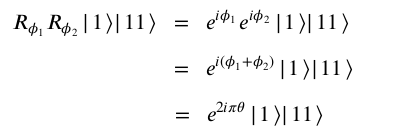

As shown above, our QPE example will take advantage of the exponential nature of applying individual $R_ϕ$ gates to create our higher order |𝑢⟩. But this time, let's see what running QPE looks like with an unknown phase:

Phases: [2.6462, 2.5779]

Combined θ: 0.83144


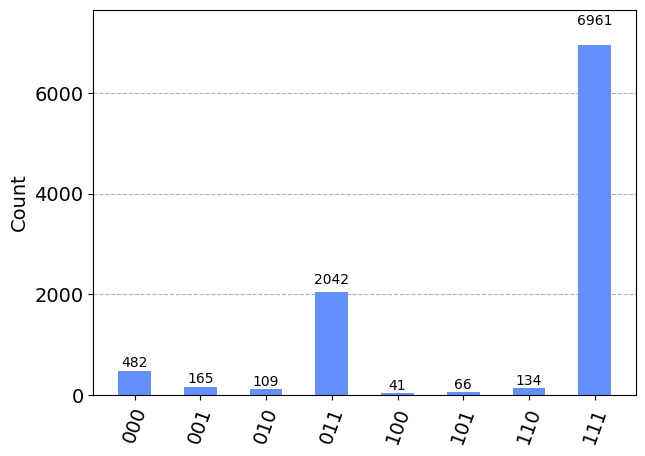

In [101]:
n1 = 3
n2 = 2
phases = []
for p in np.arange( n2 ):
  phases.append( round( 2*m.pi*random.random(),4 ) )
theta = round( sum(phases)/(2*m.pi),5)
if( theta > 1 ):
  theta = round( theta - m.floor(theta),5)
#=================================
q = QuantumRegister(n1,name='q')
qu = QuantumRegister(n2,name='qu')
c = ClassicalRegister(n1,name='c')
qc = QuantumCircuit(q,qu,c,name='qc')
#----------------------------------
for i in np.arange(n1):
  qc.h( q[int(i)] )
for i2 in np.arange(n2):
  qc.x( qu[int(i2)] )
qc.barrier()
for j in np.arange(n1):
  for j2 in np.arange(2**j):
    for j3 in np.arange(n2):
      qc.cp( phases[int(j3)], q[int(n1-1-j)], qu[int(j3)] )
  qc.barrier()
QFT_dgr( qc,q,n1,swap=True )
#---------------------------------------------------
print('Phases:',phases)
print('\nCombined \u03B8:',theta)
qc.measure(q,c)
results = execute(qc, Aer.get_backend('qasm_simulator'), shots=10000).result()
plot_histogram(results.get_counts())

Take a look at the results of our code above, and confirm for yourself that our QPE circuit is indeed picking out the correct combined θ. In particular, note the way in which the sum of our phases actually yields θ = 1.545 , but in our final answer our results show a successful QPE search for 0.545. Mathematically
this should make sense, as the two phases result in the same complex number:

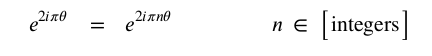

Returning to our example then, we can see that for the combined unknown 𝜃 of 0.545 our QPE has boosted the probability of the states |100⟩ and |101⟩. In particular, we see a larger probability on |100⟩ over |101⟩, which is in agreement with our 𝜃 being closer to 0.5 than 0.625. Conceptually this coding
example doesn't offer anything new beyond the previous discussions, but the takeaway here is the way in which we are able to demonstrate a higher order QPE. If you haven't already, I encourage you to play around with the code above, changing the values of $𝑛_1$ & $𝑛_2$ and seeing the various final states that arise. For our two-dimensional example, it's worth while to see the full quantum circuit, in particular the way in which each control-$𝑈^{2^n}$ operator is
implemented:

In [102]:
circuit_drawer(qc, style='clifford')

┌───┐ ░                          ░                                     »
 q_0: ┤ H ├─░──────────────────────────░─────────────────────────────────────»
      ├───┤ ░                          ░                                     »
 q_1: ┤ H ├─░──────────────────────────░──■───────────■───────────■──────────»
      ├───┤ ░                          ░  │           │           │          »
 q_2: ┤ H ├─░──■───────────■───────────░──┼───────────┼───────────┼──────────»
      ├───┤ ░  │P(2.6462)  │           ░  │P(2.6462)  │           │P(2.6462) »
qu_0: ┤ X ├─░──■───────────┼───────────░──■───────────┼───────────■──────────»
      ├───┤ ░              │P(2.5779)  ░              │P(2.5779)             »
qu_1: ┤ X ├─░──────────────■───────────░──────────────■──────────────────────»
      └───┘ ░                          ░                                     »
 c: 3/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                   ░                                                 »
« q_0: ─────────────░──■───────────■───────────■───────────■──────────»
«                   ░  │           │           │           │          »
« q_1: ─■───────────░──┼───────────┼───────────┼───────────┼──────────»
«       │           ░  │           │           │           │          »
« q_2: ─┼───────────░──┼───────────┼───────────┼───────────┼──────────»
«       │           ░  │P(2.6462)  │           │P(2.6462)  │          »
«qu_0: ─┼───────────░──■───────────┼───────────■───────────┼──────────»
«       │P(2.5779)  ░              │P(2.5779)              │P(2.5779) »
«qu_1: ─■───────────░──────────────■───────────────────────■──────────»
«                   ░                                                 »
« c: 3/═══════════════════════════════════════════════════════════════»
«                                                                     »
«                                                       ░                   »
« q_0: ─■───────────■───────────■───────────■───────────░──X────────────────»
«       │           │           │           │           ░  │                »
« q_1: ─┼───────────┼───────────┼───────────┼───────────░──┼───────■────────»
«       │           │           │           │           ░  │ ┌───┐ │P(-π/4) »
« q_2: ─┼───────────┼───────────┼───────────┼───────────░──X─┤ H ├─■────────»
«       │P(2.6462)  │           │P(2.6462)  │           ░    └───┘          »
«qu_0: ─■───────────┼───────────■───────────┼───────────░───────────────────»
«                   │P(2.5779)              │P(2.5779)  ░                   »
«qu_1: ─────────────■───────────────────────■───────────░───────────────────»
«                                                       ░                   »
« c: 3/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«                               ┌───┐┌─┐
« q_0: ──────■─────────■────────┤ H ├┤M├
«      ┌───┐ │         │P(-π/2) └┬─┬┘└╥┘
« q_1: ┤ H ├─┼─────────■─────────┤M├──╫─
«      └───┘ │P(-π/4)    ┌─┐     └╥┘  ║ 
« q_2: ──────■───────────┤M├──────╫───╫─
«                        └╥┘      ║   ║ 
«qu_0: ───────────────────╫───────╫───╫─
«                         ║       ║   ║ 
«qu_1: ───────────────────╫───────╫───╫─
«                         ║       ║   ║ 
« c: 3/═══════════════════╩═══════╩═══╩═
«                         2       1   0

In the circuit diagram above, we've used the barrier() function to separate out each control-$U^{2^n}$ operator. As you can see, a single implementation of our
𝑛
control gate is achieved through $R_{ϕ_1}$ and $R_{ϕ_2}$ , acting on their respective target qubits in $|u⟩$. Then, each successive control-$U^{2^n}$ is simply a repetition of these two gates $2^n$ times.

With the code for implementing a random phase above now complete, our final example will look to implement the θ approximation technique from earlier. Specifically, we will take our measurement results and attempt to reconstruct θ using the $|⟨𝑚|Ψ_{final}⟩|^2$ formula:

In [103]:
n1 = 5
n2 = 3
phases = []
trials = 10000
for p in np.arange( n2 ):
  phases.append( round( 2*m.pi*random.random(),4 ) )
theta = round( sum(phases)/(2*m.pi),5)
if( theta > 1 ):
  theta = round( theta - m.floor(theta),5)
#================================================================== QPE Circuit
q = QuantumRegister(n1,name='q')
qu = QuantumRegister(n2,name='qu')
c = ClassicalRegister(n1,name='c')
qc = QuantumCircuit(q,qu,c,name='qc')
#-------------------------------------
for i in np.arange(n1):
  qc.h( q[int(i)] )
for i2 in np.arange(n2):
  qc.x( qu[int(i2)] )
for j in np.arange(n1):
  for j2 in np.arange(2**j):
    for j3 in np.arange(n2):
      qc.cp( phases[int(j3)], q[int(n1-1-j)], qu[int(j3)] )
QFT_dgr( qc,q,n1,swap=True )
#==================================================================
print('Phases: ',phases,' Combined \u03B8:',theta)
qc.measure(q,c)
M = Measurement( qc,systems=[n1,n2],shots=trials,return_M=True,print_M=False )
MP = Most_Probable(M,2)
for mp in np.arange(2):
  MP[0][mp] = MP[0][mp]/trials
phi,theta = QPE_phi(MP)
print('\nMost Probable State:|'+str(MP[1][0])+'> Probability: ',round(MP[0][0],5))
print('\nSecond Most Probable: |'+str(MP[1][1])+'> Probability: ',round(MP[0][1],5))
print('\nCorresponding \u03A6: ',phi,'\n\nApproximate \u03B8: ',round(theta,5))

Phases:  [6.1756, 3.1522, 4.2055]  Combined θ: 0.15389

Most Probable State:|00101> Probability:  0.4686

Second Most Probable: |00111> Probability:  0.2995

Corresponding Φ:  0.4618 

Approximate θ:  0.17068


And there we have it, our complete QPE example using the function QPE_phi() to approximate θ using repeat measurements! In the example shown above
we've elected to use 5 qubits for accuracy, and 3 for our eigenstate $|u⟩$. There's certainly a lot to unpack in this final example, so I encourage you to play around with it, dissecting it as needed to really get a strong understanding of QPE. 

Like we mentioned at the top of this section, the ideal role for QPE would be to help find an eigenvalue of some unknown $U$. However, in order to do this, QPE requires that we:

1. Have a means of physicalling implementing 𝑈 as a control operator in our quantum circuit
2. Know the eigenstate |𝑢⟩ corresponding to the eigenvalue we're interested in
3. Have a means for constructing |𝑢⟩ (arbitrary state preparation is no easy task in quantum computing)

These three reasons are why we put off creating the quantum code for QPE to the very end of this lesson. Our goal in this lab session is to understand the
fundamentals that make up QPE, which are circuit implementation agnostic. And now that we have these fundamentals, the real challenge lies in applying
them to real world problems where QPE is viable.

## **References**
***
1. A. Y. Kitaev, "Quantum measurements and the Abelian Stabilizer Problem", arXiv:9511026 (1995)
2. [Qiskit Notebook QPE](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation)